# Sentiment analysis of beauty products based on reviews from wizaz.pl
## Table of Contents

[1. Abstract](#chapter1)  
[2. Prerequisites](#chapter2)  
[3. Introduction to dataset](#chapter3)  
[4. Text cleaning](#chapter4)  
[5. Sentiment analysis](#chapter5)  
[6. Relevance of features](#chapter6)  
[7. Criticism](#chapter7)  

## 1. Abstract <a class="anchor" id="chapter1"></a>

The notebook presents sentiment analysis of reviews of face creams from [wizaz.pl](https://wizaz.pl/) - the largest Polish database with reviews on cosmetics. The goal of the project was to develop a model, which would classify whether a review is positive, negative or neutral. 

Prior to modelling, the data have been undersampled (due to imbalance of classes) and cleaned. A few types of models have been tested, such as Naive Bayes, logistic regression, random forests and SVM. Logistic regresstion was selected as the best performing one with accuracy on test dataset equal to 75%. At the end, the inspection of most relevant features affecting the sentiment of reviews was performed.

## 2. Prerequisites <a class="anchor" id="chapter2"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import nltk
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
import spacy
import re
import string
import csv
import pickle
import language_tool_python
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
import time

rs = 124

params = {'axes.labelsize': 12,
         'axes.titlesize':20,
         'xtick.labelsize':12,
         'ytick.labelsize':12
}
plt.rcParams.update(params) 

## 3. Introduction to dataset <a class="anchor" id="chapter3"></a>

An exemplary review from wizaz.pl is presented below. It consists of the title, main body and 'pros and cons' section (however, the latter is often left blank). The form of review is not stictly imposed. Both body and 'pros and cons' section can be bullets or a series of sentences. The users give ratings from 1 to 5 (only integer values are allowed).

<img src="files/Sample_review.JPG">

The full dataset contains 67,512 reviews of 4,409 products.

In [2]:
reviews_df = pd.read_excel('data/reviews_full_df.xlsx')
reviews_df

,review_id,product_id,product_name,brand,user,date,grade,review_title,review_body,review_pros,review_cons
0,0,0,"Nivea, Soft, Krem do twarzy i ciała (nowa wersja)",Nivea,Beata_Ewa,2021-08-19,4,Krem Nivea,+ ładny zapach\n\r\n+ nawilżenie\n\r\n+ korzys...,NaN,NaN
1,1,0,"Nivea, Soft, Krem do twarzy i ciała (nowa wersja)",Nivea,testujeasik,2021-07-17,4,Lubię za uniwersalność,Znacie to uczucie jak testujecie kilka produkt...,Cena \r\nPojemność,NaN
2,2,0,"Nivea, Soft, Krem do twarzy i ciała (nowa wersja)",Nivea,martynaq1995,2021-06-30,5,Soft !,Jest to krem bardzo uniwersalny. Mogą go stoso...,-Zapach \r\n-konsystencja \r\n-wydajność \r\n...,-skład
3,3,0,"Nivea, Soft, Krem do twarzy i ciała (nowa wersja)",Nivea,Refleksja81,2021-06-19,5,"Klasyk, bez którego nie wyobrażam sobie sezonu...","To kosmetyk, do którego z przyjemnością wracam...",NaN,NaN
4,4,0,"Nivea, Soft, Krem do twarzy i ciała (nowa wersja)",Nivea,alboco,2021-06-14,5,Dobrze nawilża,Produkt w zasadzie dość podobny do klasycznej ...,wielofunkcyjność \r\ndostępność \r\nduża poje...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
67507,67513,4404,"A-Derma, Dermalibour + Barrier Creme Protectri...",A-Derma,only_truth,2020-12-30,1,"Nie spełnia swojej funkcji, ani jednej","Krem ten miał być ochronnym, przed mrozem, wia...",brak,- zbyt wygórowana cena \r\n- zapycha pory \r\...
67508,67514,4405,"AA, Enjoy Nature, Wzmacniający krem łagodzący ...",AA,werkakaka,2021-07-15,1,TOTALNY Zapychacz,nie polecajka\n\r\nRaz chciałam kupić coś tańs...,NaN,NaN
67509,67515,4406,"Nivelazione, Color Skin Help Whitening Cream (...",Nivelazione,_inga,2021-08-01,1,"Krem wybielający przebarwienia i piegi, Nivela...",Krem kupiłam na jednej z aukcji internetowych\...,"- konsystencja \r\n- nie uczula, nie podrażni...",- brak zauważalnego efektu wybielania przebar...
67510,67516,4407,"Ingrid Cosmetics, Rejuvenating Pumpkin Cream (...",Ingrid Cosmetics,Greenpath,2021-07-09,1,Ingrid odmładzający krem do twarzy z dynią 97%...,"Hmm specjalnie założyłam konto,aby dodać opini...",Opakowanie \r\nZapach ok,Skład kremu niby 97% pochodzenia naturalnego ...


Unfortunately, classes in the full dataset are unbalanced. The highest grade makes up over 55% of all observations, while each of grades 1 and 2 constitute around 6%. Therefore, I applied undersampling of the data. I also aggregated grades 1-5 into 3 classes: negative (labeled as 0): 1, 2; neutral (1): 3 and positive (2): 4, 5. The resampled dataset constains 22,365 reviews (7,455 reviews per class).

In [3]:
grades_summary = pd.DataFrame({'number_of_reviews': reviews_df['grade'].value_counts(sort=False)})
grades_summary['share'] = grades_summary['number_of_reviews']/grades_summary['number_of_reviews'].sum()
grades_summary

,number_of_reviews,share
1,3820,0.056583
2,4339,0.064270
3,7455,0.110425
4,14670,0.217295
5,37228,0.551428


In [4]:
grades_mapping = {1:0, 2:0, 3:1, 4:2, 5:2}
grades = np.array([grades_mapping.get(x) for x in reviews_df['grade']])
grades

array([2, 2, 2, ..., 0, 0, 0])

In [5]:
reviews_columns = ['review_title', 'review_body', 'review_pros', 'review_cons']
reviews_df[reviews_columns] = reviews_df[reviews_columns].fillna('')
reviews = reviews_df[reviews_columns].values

rus = RandomUnderSampler(random_state=rs)
reviews_resampled, grades_resampled = rus.fit_resample(reviews, grades)

print(np.unique(grades_resampled, return_counts=True))
print(f'Length of resampled dataset: {len(grades_resampled)}')

(array([0, 1, 2]), array([7455, 7455, 7455], dtype=int64))
Length of resampled dataset: 22365


In [6]:
grades_resampled = list(grades_resampled)
reviews_resampled  = [list(reviews_resampled[i]) for i in range(len(reviews_resampled))]

## 4. Text cleaning <a class="anchor" id="chapter4"></a>

The data need to be cleaned before modelling. One of the challanges related to analysis of reviews are frequent typing errors. This problem is exacerbated in the case of Polish language due to presence of native characters, which are often replaced with their non-native equivalents (e.g. 'e' is often used instead of 'ę'). In the first step, I used methods available in `LanguageTool` class from `language_tool_python` package, which enabled me to correct errors of this type.

In [9]:
reviews_resampled[:3]

[['co to jest?',
  'Dużo recenzentek chwali ten krem, a dla mnie on nic nie wnosi. Po prostu skóra zachowuje się biernie wobec niego. Nie widzę poprawy, może nawet się pogorszyła jak go używałam. Bardziej się przetłuszczała. Nic dobrego nie wnosił do mojej pielęgnacji. Chyba wolę wydać więcej kasy na inny krem, który zadziała.\n\n\n\nUżywam tego produktu od: 3 miesięcy (przestałam regularnie bo i tak nic nie daje)\n\nIlość zużytych opakowań: 1 w trakcie',
  '',
  ''],
 ['kleista porażka',
  'Osobiście mam problem z tym produktem - nałożenie niewielkiej ilości skutkuje niewystarczającym nawilżeniem; nałożenie konkretnej warstwy nawilża, jednak krem nie wchłania się wtedy wystarczająco. Nawet jeśli mam czas poczekać, aż wszystko wyschnie krem klei się na twarzy i bardzo mocno błyszczy.',
  ' nawilża',
  ' kleista formuła \r\nmocno się błyszczy \r\nnie nadaje się pod makijaż'],
 ['Dramat',
  'Kupiłam ten krem podczas promocji w SuperPharm za 9 zł, po wielu zachwalaniach pan sprzedajacych.

In [10]:
tool = language_tool_python.LanguageTool('pl')

def correct_spelling_mistakes(text, tool):
    matches = tool.check(text)
    result = language_tool_python.utils.correct(text, matches)
    return result

reviews_resampled = [[correct_spelling_mistakes(section, tool) for section in review] for review in reviews_resampled]
reviews_resampled[:3]

[['Co to jest?',
  'Dużo recenzentek chwali ten krem, a dla mnie on nic nie wnosi. Po prostu skóra zachowuje się biernie wobec niego. Nie widzę poprawy, może nawet się pogorszyła jak go używałam. Bardziej się przetłuszczała. Nic dobrego nie wnosił do mojej pielęgnacji. Chyba wolę wydać więcej kasy na inny krem, który zadziała.\n\n\n\nUżywam tego produktu od: 3 miesięcy (przestałam regularnie, bo i tak nic nie daje)\n\nIlość zużytych opakowań: 1 w trakcie',
  '',
  ''],
 ['Kleista porażka',
  'Osobiście mam problem z tym produktem-nałożenie niewielkiej ilości skutkuje niewystarczającym nawilżeniem; nałożenie konkretnej warstwy nawilża, jednak krem nie wchłania się wtedy wystarczająco. Nawet jeśli mam czas poczekać, aż wszystko wyschnie krem klei się na twarzy i bardzo mocno błyszczy.',
  ' Nawilża',
  ' Kleista formuła \r\nmocno się błyszczy \r\nnie nadaje się pod makijaż'],
 ['Dramat',
  'Kupiłam ten krem podczas promocji w SuperPharm za 9 zł, po wielu zachwalaniach pan sprzedających.\

In [11]:
# pickle.dump(reviews_resampled, open('data/reviews_resampled_text_corrected.pkl', 'wb'))
# reviews_resampled = pickle.load(open('data/reviews_resampled_text_corrected.pkl', 'rb'))

Secondly, I carried out basic text cleaning, which included, i.a., transformation into lower case, deletion of multiple spaces and dots as well as special chcaracters (incl. emojis) and tokenization.

In [12]:
reviews_resampled = [[section.lower() for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub('\n',' ',  section) for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub('\r',' ',  section) for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub(r'\\',' ', section) for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub('/',' ', section) for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub('\d',' ', section) for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub('\.{2,}','.', section) for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub('\s{2,}',' ', section) for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub('[•–‚…]', '', section) for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub('(?<=[.,])(?=[^\s])', ' ', section) for section in review] for review in reviews_resampled]
reviews_resampled = [[re.sub(u'\\u200b','', section) for section in review] for review in reviews_resampled]

emoji_pattern = re.compile('['
                           u'\U0001F600-\U0001F64F'  
                           u'\U0001F300-\U0001F5FF'  
                           u'\U0001F680-\U0001F6FF'  
                           u'\U0001F1E0-\U0001F1FF'  
                           u'\U00002702-\U000027B0'
                           u'\U000024C2-\U0001F251'
                           ']+', flags=re.UNICODE)
reviews_resampled = [[emoji_pattern.sub(r'', section) for section in review] for review in reviews_resampled]

reviews_resampled[:3]

[['co to jest?',
  'dużo recenzentek chwali ten krem, a dla mnie on nic nie wnosi. po prostu skóra zachowuje się biernie wobec niego. nie widzę poprawy, może nawet się pogorszyła jak go używałam. bardziej się przetłuszczała. nic dobrego nie wnosił do mojej pielęgnacji. chyba wolę wydać więcej kasy na inny krem, który zadziała. używam tego produktu od: miesięcy (przestałam regularnie, bo i tak nic nie daje) ilość zużytych opakowań: w trakcie',
  '',
  ''],
 ['kleista porażka',
  'osobiście mam problem z tym produktem-nałożenie niewielkiej ilości skutkuje niewystarczającym nawilżeniem; nałożenie konkretnej warstwy nawilża, jednak krem nie wchłania się wtedy wystarczająco. nawet jeśli mam czas poczekać, aż wszystko wyschnie krem klei się na twarzy i bardzo mocno błyszczy.',
  ' nawilża',
  ' kleista formuła mocno się błyszczy nie nadaje się pod makijaż'],
 ['dramat',
  'kupiłam ten krem podczas promocji w superpharm za zł, po wielu zachwalaniach pan sprzedających. jeszcze nigdy po żadnym 

In [13]:
reviews_resampled = [[word_tokenize(section) for section in review] for review in reviews_resampled]
print(reviews_resampled[:3])

[[['co', 'to', 'jest', '?'], ['dużo', 'recenzentek', 'chwali', 'ten', 'krem', ',', 'a', 'dla', 'mnie', 'on', 'nic', 'nie', 'wnosi', '.', 'po', 'prostu', 'skóra', 'zachowuje', 'się', 'biernie', 'wobec', 'niego', '.', 'nie', 'widzę', 'poprawy', ',', 'może', 'nawet', 'się', 'pogorszyła', 'jak', 'go', 'używałam', '.', 'bardziej', 'się', 'przetłuszczała', '.', 'nic', 'dobrego', 'nie', 'wnosił', 'do', 'mojej', 'pielęgnacji', '.', 'chyba', 'wolę', 'wydać', 'więcej', 'kasy', 'na', 'inny', 'krem', ',', 'który', 'zadziała', '.', 'używam', 'tego', 'produktu', 'od', ':', 'miesięcy', '(', 'przestałam', 'regularnie', ',', 'bo', 'i', 'tak', 'nic', 'nie', 'daje', ')', 'ilość', 'zużytych', 'opakowań', ':', 'w', 'trakcie'], [], []], [['kleista', 'porażka'], ['osobiście', 'mam', 'problem', 'z', 'tym', 'produktem-nałożenie', 'niewielkiej', 'ilości', 'skutkuje', 'niewystarczającym', 'nawilżeniem', ';', 'nałożenie', 'konkretnej', 'warstwy', 'nawilża', ',', 'jednak', 'krem', 'nie', 'wchłania', 'się', 'wtedy'

Third, I removed tokens that are punctuation marks and stripped tokens of punctuation marks (as users often write reviews in the form of bullets of various types). I also removed tokens of length below 3. One exception is 'nie' (*ang. no, not*), which was replaced with a special tag in order to handle negations in the analysis.

In [14]:
reviews_resampled = [[[token for token in section if token not in string.punctuation] \
                      for section in review] \
                         for review in reviews_resampled]
reviews_resampled = [[[token.strip(string.punctuation) for token in section] \
                      for section in review] \
                         for review in reviews_resampled]
reviews_resampled = [[['_nie_' if token=='nie' else token for token in section] \
                      for section in review] \
                         for review in reviews_resampled]
reviews_resampled = [[[token for token in section if len(token)>3] \
                      for section in review]  \
                     for review in reviews_resampled]
print(reviews_resampled[:3])

[[['jest'], ['dużo', 'recenzentek', 'chwali', 'krem', 'mnie', '_nie_', 'wnosi', 'prostu', 'skóra', 'zachowuje', 'biernie', 'wobec', 'niego', '_nie_', 'widzę', 'poprawy', 'może', 'nawet', 'pogorszyła', 'używałam', 'bardziej', 'przetłuszczała', 'dobrego', '_nie_', 'wnosił', 'mojej', 'pielęgnacji', 'chyba', 'wolę', 'wydać', 'więcej', 'kasy', 'inny', 'krem', 'który', 'zadziała', 'używam', 'tego', 'produktu', 'miesięcy', 'przestałam', 'regularnie', '_nie_', 'daje', 'ilość', 'zużytych', 'opakowań', 'trakcie'], [], []], [['kleista', 'porażka'], ['osobiście', 'problem', 'produktem-nałożenie', 'niewielkiej', 'ilości', 'skutkuje', 'niewystarczającym', 'nawilżeniem', 'nałożenie', 'konkretnej', 'warstwy', 'nawilża', 'jednak', 'krem', '_nie_', 'wchłania', 'wtedy', 'wystarczająco', 'nawet', 'jeśli', 'czas', 'poczekać', 'wszystko', 'wyschnie', 'krem', 'klei', 'twarzy', 'bardzo', 'mocno', 'błyszczy'], ['nawilża'], ['kleista', 'formuła', 'mocno', 'błyszczy', '_nie_', 'nadaje', 'makijaż']], [['dramat'],

Forth, I lemmatized the tokens. For this purpose, I used SJP. It is a Polish dictionary, which can be downloaded [here](https://sjp.pl/slownik/odmiany/).

In [15]:
dictionary = {}

with open('lemmatizer/odm.txt', newline='\n', encoding='UTF-8') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    reader = [[word.strip().lower() for word in row] for row in reader]
    for row in reader:
        if len(row) > 1:
            base, *sec = row
            for s in sec:
                dictionary[s] = base

def lemmatize(token, dictionary):
    return dictionary.get(token, token)

reviews_resampled = [[[lemmatize(token, dictionary) for token in section] \
                      for section in review] \
                         for review in reviews_resampled]
print(reviews_resampled[:3])

[[['być'], ['duży', 'recenzentka', 'chwalić', 'krem', 'miąć', '_nie_', 'wnosić', 'prostu', 'skóra', 'zachowywać', 'bierny', 'wobec', 'on', '_nie_', 'widzieć', 'poprawa', 'móc', 'nawet', 'pogorszyć', 'używać', 'bardziej', 'przetłuszczać', 'dobry', '_nie_', 'wnosić', 'mój', 'pielęgnacja', 'chyba', 'woleć', 'wydać', 'więcej', 'kasa', 'inny', 'krem', 'który', 'zadziałać', 'używać', 'ten', 'produkt', 'miesiąc', 'przestać', 'regularny', '_nie_', 'dawać', 'ilość', 'zużyty', 'opakowanie', 'trakt'], [], []], [['kleisty', 'porażka'], ['osobisty', 'problem', 'produktem-nałożenie', 'wielki', 'ilość', 'skutkować', 'wystarczający', 'nawilżyć', 'nałożyć', 'konkretny', 'warstwa', 'nawilżać', 'jednak', 'krem', '_nie_', 'wchłaniać', 'wtedy', 'wystarczający', 'nawet', 'jeśli', 'czas', 'poczekać', 'wszystek', 'wyschnąć', 'krem', 'kleić', 'twarz', 'bardzo', 'mocny', 'błyszczeć'], ['nawilżać'], ['kleisty', 'formuła', 'mocny', 'błyszczeć', '_nie_', 'nadawać', 'makijaż']], [['dramat'], ['kupić', 'krem', 'podc

Fifth, I removed stop words. For this purpose, I used `stop_words` package, which offers a list of 138 Polish stop words. This step was performed after lemmatization due to the fact that some Polish stop words have several secondary forms (e.g. twój, twojego, twojemu).

In [16]:
stop_words = get_stop_words('pl')
print(stop_words)

['ach', 'aj', 'albo', 'bardzo', 'bez', 'bo', 'być', 'ci', 'cię', 'ciebie', 'co', 'czy', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokąd', 'dość', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dziś', 'dzisiaj', 'gdyby', 'gdzie', 'go', 'ich', 'ile', 'im', 'inny', 'ja', 'ją', 'jak', 'jakby', 'jaki', 'je', 'jeden', 'jedna', 'jedno', 'jego', 'jej', 'jemu', 'jeśli', 'jest', 'jestem', 'jeżeli', 'już', 'każdy', 'kiedy', 'kierunku', 'kto', 'ku', 'lub', 'ma', 'mają', 'mam', 'mi', 'mną', 'mnie', 'moi', 'mój', 'moja', 'moje', 'może', 'mu', 'my', 'na', 'nam', 'nami', 'nas', 'nasi', 'nasz', 'nasza', 'nasze', 'natychmiast', 'nią', 'nic', 'nich', 'nie', 'niego', 'niej', 'niemu', 'nigdy', 'nim', 'nimi', 'niż', 'obok', 'od', 'około', 'on', 'ona', 'one', 'oni', 'ono', 'owszem', 'po', 'pod', 'ponieważ', 'przed', 'przedtem', 'są', 'sam', 'sama', 'się', 'skąd', 'tak', 'taki', 'tam', 'ten', 'to', 'tobą', 'tobie', 'tu', 'tutaj', 'twoi', 'twój', 'twoja', 'twoje', 'ty', 'wam', 'wami', 'was', 'wasi', '

In [17]:
reviews_resampled = [[[token for token in section if token not in stop_words] \
                      for section in review] \
                         for review in reviews_resampled]
print(reviews_resampled[:3])

[[[], ['duży', 'recenzentka', 'chwalić', 'krem', 'miąć', '_nie_', 'wnosić', 'prostu', 'skóra', 'zachowywać', 'bierny', 'wobec', '_nie_', 'widzieć', 'poprawa', 'móc', 'nawet', 'pogorszyć', 'używać', 'bardziej', 'przetłuszczać', 'dobry', '_nie_', 'wnosić', 'pielęgnacja', 'chyba', 'woleć', 'wydać', 'więcej', 'kasa', 'krem', 'który', 'zadziałać', 'używać', 'produkt', 'miesiąc', 'przestać', 'regularny', '_nie_', 'dawać', 'ilość', 'zużyty', 'opakowanie', 'trakt'], [], []], [['kleisty', 'porażka'], ['osobisty', 'problem', 'produktem-nałożenie', 'wielki', 'ilość', 'skutkować', 'wystarczający', 'nawilżyć', 'nałożyć', 'konkretny', 'warstwa', 'nawilżać', 'jednak', 'krem', '_nie_', 'wchłaniać', 'wystarczający', 'nawet', 'czas', 'poczekać', 'wszystek', 'wyschnąć', 'krem', 'kleić', 'twarz', 'mocny', 'błyszczeć'], ['nawilżać'], ['kleisty', 'formuła', 'mocny', 'błyszczeć', '_nie_', 'nadawać', 'makijaż']], [['dramat'], ['kupić', 'krem', 'podczas', 'promocja', 'superpharm', 'wiele', 'zachwalać', 'sprzed

Finally, I received 35,965 unique tokens. The full list of unique tokens can be found in *data/unique_tokens_df.xlsx*.

In [18]:
all_tokens = nltk.flatten(reviews_resampled)
counter = {}

for w in all_tokens:
    counter[w] = counter.get(w,0)+1

counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1], reverse = True)}
print(f'There are {len(counter.keys())} unique tokens.')

unique_tokens = [k for k in counter.keys()]
unique_tokens_sorted = sorted(unique_tokens)
counts = [v for v in counter.values()]

unique_tokens_df = pd.DataFrame()
unique_tokens_df['token'] = unique_tokens
unique_tokens_df['count'] = counts
unique_tokens_df.to_excel('data/unique_tokens_df.xlsx', encoding = 'utf-8', index=False)

There are 35965 unique tokens.


 The chart below presents the most frequent tokens. They are indeed linked to the subject of cosmetics, e.g. 'krem' (*'cream'*), 'skóra' (*'skin'*), 'twarz' (*'face'*), 'zapach' (*'fragrance'*), 'nawilżać'/'nawilżyć' (*'moisturize'*). However, some of them are pretty neutral, e.g. 'który' (*'which'*), 'móc' (*'can'*), 'mieć' (*'have'*). 

The chart also suggest some incorrect mappings to base form in the lemmatization step, e.g 'miąć' ('crumple') was probably confused with 'mieć' (*'have'*). This might be caused, i.a., by ambiguity of some words. Nonetheless, this issue will not be approached in the analysis. 

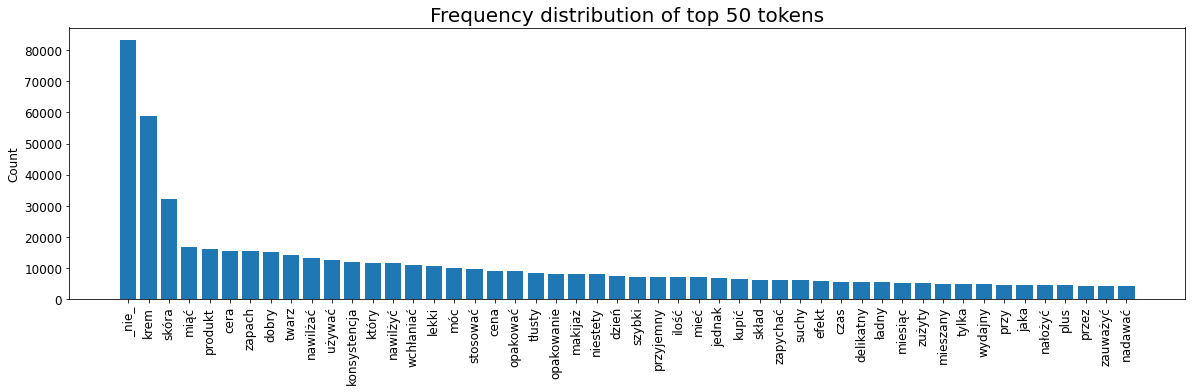

In [19]:
n = 50

plt.figure(figsize=(20, 5))
plt.bar(x = unique_tokens[:n], height = counts[:n])
plt.title(f'Frequency distribution of top {n} tokens')
plt.ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

At the end, I marked tokens from the 'pros and cons' section with special tags. The purpose is to examine the relations between sentiments and appearance of tokens in individual sections of reviews. The tokens from the titles were not distinguished as titles are often integrated with the bodies of reviews.

In [21]:
reviews_resampled_final = []

for review in reviews_resampled:
    
    pros_tagged = ['_pros_' + token for token in review[2]]
    cons_tagged = ['_cons_' + token for token in review[3]]
    review_merged = nltk.flatten(review[0], review[1], pros_tagged, cons_tagged)
    reviews_resampled_final.append(review_merged)

print(reviews_resampled_final[:3])

[['duży', 'recenzentka', 'chwalić', 'krem', 'miąć', '_nie_', 'wnosić', 'prostu', 'skóra', 'zachowywać', 'bierny', 'wobec', '_nie_', 'widzieć', 'poprawa', 'móc', 'nawet', 'pogorszyć', 'używać', 'bardziej', 'przetłuszczać', 'dobry', '_nie_', 'wnosić', 'pielęgnacja', 'chyba', 'woleć', 'wydać', 'więcej', 'kasa', 'krem', 'który', 'zadziałać', 'używać', 'produkt', 'miesiąc', 'przestać', 'regularny', '_nie_', 'dawać', 'ilość', 'zużyty', 'opakowanie', 'trakt'], ['kleisty', 'porażka', 'osobisty', 'problem', 'produktem-nałożenie', 'wielki', 'ilość', 'skutkować', 'wystarczający', 'nawilżyć', 'nałożyć', 'konkretny', 'warstwa', 'nawilżać', 'jednak', 'krem', '_nie_', 'wchłaniać', 'wystarczający', 'nawet', 'czas', 'poczekać', 'wszystek', 'wyschnąć', 'krem', 'kleić', 'twarz', 'mocny', 'błyszczeć', '_pros_nawilżać', '_cons_kleisty', '_cons_formuła', '_cons_mocny', '_cons_błyszczeć', '_cons__nie_', '_cons_nadawać', '_cons_makijaż'], ['dramat', 'kupić', 'krem', 'podczas', 'promocja', 'superpharm', 'wiele

In [10]:
# pickle.dump(reviews_resampled_final, open('data/reviews_resampled_final.pkl', 'wb'))
# reviews_resampled_final = pickle.load(open('data/reviews_resampled_final.pkl', 'rb'))

## 5. Sentiment analysis <a class="anchor" id="chapter5"></a>

Prior to modelling, the data were splitted into train and test dataset. The size of test dataset was set to 20% of observations.

In [11]:
reviews_resampled_final_joined = [' '.join(review) for review in reviews_resampled_final]
X_train, X_test, y_train, y_test = train_test_split(reviews_resampled_final_joined, grades_resampled, test_size = 0.2, 
                                                    random_state = rs)

I included 4 types of models in the analysis: Naive Bayes, logistic regression, random forests and SVM. In the case of logistic regression, I tested several values of inverse of L2 regularization strength. For each model, I used `CountVectorizer` to transform texts into a matrix. In this step, I tested several cut-off points related to minimum and maximum number of occurances of tokens. I also changed default value of `ngram_range` parameter in order to include both individual tokens and combinations of 2 subsequent tokens. Moreover, I allowed reduction of dimensions using `TruncatedSVD` (both reduction into 100 components and no reduction were tested).

In [10]:
model_names = ['Naive Bayes', 'Logistic Regression', 'Random Forests', 'SVM']

models = [make_pipeline(CountVectorizer(), TruncatedSVD(), BernoulliNB()),
          make_pipeline(CountVectorizer(), TruncatedSVD(), LogisticRegression(solver='saga', random_state=rs)),
          make_pipeline(CountVectorizer(), TruncatedSVD(), RandomForestClassifier(random_state=rs)),
          make_pipeline(CountVectorizer(), TruncatedSVD(), SVC(random_state=rs))
         ]

param_grids_models = [ {},
    
                      [{'logisticregression__penalty': ['none']},
                       {'logisticregression__C': [0.001, 0.01, 0.1, 10],
                        'logisticregression__penalty': ['l2']}],
                     
                       {'randomforestclassifier__n_estimators': [50, 100, 200, 500, 1000],
                        'randomforestclassifier__min_samples_leaf': [50, 100, 200]},
                      
                       {'svc__kernel': ['linear']},
                      ]

param_grid_vectorizer = {'countvectorizer__min_df': [50, 100, 300, 500],
                         'countvectorizer__max_df': [0.1, 0.15, 0.3, 0.5],
                         'countvectorizer__ngram_range': [(1, 2)]}
               
param_grids_svd = [{'truncatedsvd': ['passthrough']},
                   {'truncatedsvd__n_components': [100]}]


The full set of grids to be tested can be seen below.

In [11]:
param_grids = []

for i, param_grid_models in enumerate(param_grids_models):
    
        param_grids.append([])
        
        for param_grid_svd in param_grids_svd:

            if isinstance(param_grid_models, dict):
                dicts = [param_grid_models, param_grid_vectorizer, param_grid_svd]
                grid = {k:v for d in dicts for k,v in d.items()}
                param_grids[i].append(grid)
            else:
                for param_grid_models_item in param_grid_models:
                    dicts = [param_grid_models_item, param_grid_vectorizer, param_grid_svd]
                    grid = {k:v for d in dicts for k,v in d.items()}
                    param_grids[i].append(grid)
        
param_grids

[[{'countvectorizer__min_df': [50, 100, 300, 500],
   'countvectorizer__max_df': [0.1, 0.15, 0.3, 0.5],
   'countvectorizer__ngram_range': [(1, 2)],
   'truncatedsvd': ['passthrough']},
  {'countvectorizer__min_df': [50, 100, 300, 500],
   'countvectorizer__max_df': [0.1, 0.15, 0.3, 0.5],
   'countvectorizer__ngram_range': [(1, 2)],
   'truncatedsvd__n_components': [100]}],
 [{'logisticregression__penalty': ['none'],
   'countvectorizer__min_df': [50, 100, 300, 500],
   'countvectorizer__max_df': [0.1, 0.15, 0.3, 0.5],
   'countvectorizer__ngram_range': [(1, 2)],
   'truncatedsvd': ['passthrough']},
  {'logisticregression__C': [0.001, 0.01, 0.1, 10],
   'logisticregression__penalty': ['l2'],
   'countvectorizer__min_df': [50, 100, 300, 500],
   'countvectorizer__max_df': [0.1, 0.15, 0.3, 0.5],
   'countvectorizer__ngram_range': [(1, 2)],
   'truncatedsvd': ['passthrough']},
  {'logisticregression__penalty': ['none'],
   'countvectorizer__min_df': [50, 100, 300, 500],
   'countvectorize

I tuned the hyperparametres using `GridSearchCV`. For each model, 5-fold cross validation was performed. Accuracy was selected as a metric to assess the models' performance.

It can be seen that all models gained similar results. Best accuracy on test dataset ranged from 69% for fandom forests and 75% for logistic regression. The best performing model was logistic regression with 1) C=0.01, 2) no reduction of dimensions, 3) minimum number of occurances equal to 50, 4) maximum percentage of occurences equal to 50%.

In [12]:
best_models = []
test_scores = []
train_scores = []
cv = KFold(n_splits=5, shuffle=True, random_state=rs)

loop_start_time = time.time()

for i, (model, grids) in enumerate(zip(models, param_grids)):
    
    _best_models = []
    _test_scores = []
    _train_scores = []
    
    for grid in grids:
        
        optimizer = GridSearchCV(model,
                                param_grid=grid,
                                cv=cv,
                                scoring = 'accuracy', 
                                n_jobs =-1) 

        optimizer.fit(X_train, y_train)

        test_accuracy = accuracy_score(y_test, optimizer.best_estimator_.predict(X_test))
        train_accuracy = accuracy_score(y_train, optimizer.best_estimator_.predict(X_train))
        
        _best_models.append(optimizer.best_estimator_)
        _test_scores.append(test_accuracy)
        _train_scores.append(train_accuracy)
    
    best_test_accuracy = max(_test_scores)
    idx = _test_scores.index(best_test_accuracy)
    best_train_accuracy = _train_scores[idx]
    best_model = _best_models[idx]
    best_models.append(best_model)
    test_scores.append(best_test_accuracy)
    train_scores.append(best_train_accuracy)
    
    print(f'{model_names[i]}:')
    print(f'Best accuracy on test dataset: {best_test_accuracy}')
    print(f'Corresponding accuracy on train dataset: {best_train_accuracy}')
    print('Best model:')
    print(best_model)
    
    current_time = time.time()
    print(f'It has been {round((current_time - loop_start_time)/60, 0)} minutes since the loop started.\n')


Naive Bayes:
Best accuracy on test dataset: 0.7281466577241225
Corresponding accuracy on train dataset: 0.75380058126537
Best model:
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.15, min_df=50, ngram_range=(1, 2))),
                ('truncatedsvd', 'passthrough'),
                ('bernoullinb', BernoulliNB())])
It has been 4.0 minutes since the loop started.



The max_iter was reached which means the coef_ did not converge


Logistic Regression:
Best accuracy on test dataset: 0.7540800357701766
Corresponding accuracy on train dataset: 0.8066174826738207
Best model:
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.5, min_df=50, ngram_range=(1, 2))),
                ('truncatedsvd', 'passthrough'),
                ('logisticregression',
                 LogisticRegression(C=0.01, random_state=124, solver='saga'))])
It has been 24.0 minutes since the loop started.

Random Forests:
Best accuracy on test dataset: 0.6910350994858037
Corresponding accuracy on train dataset: 0.7083053878828527
Best model:
Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.3, min_df=50, ngram_range=(1, 2))),
                ('truncatedsvd', 'passthrough'),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=50, n_estimators=1000,
                                        random_state=124))])
It has been 209.0 minutes since the loop

In [18]:
model = best_models[np.argmax(test_scores)]
print(model)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.5, min_df=50, ngram_range=(1, 2))),
                ('truncatedsvd', 'passthrough'),
                ('logisticregression',
                 LogisticRegression(C=0.01, random_state=124, solver='saga'))])


Confusion matrix for the best model is presented below. It can be seen that the easiest class to predict was 'positive' (almost 86% of all instances of this class in a test dataset were classified correctly),  while the 'neutral' class was the most difficult one (64% of correct classifications). The model most often confused the 'negative' class with the 'neutral' class.

In [67]:
np.set_printoptions(suppress=True)

cmt  = confusion_matrix(y_test, model.predict(X_test)).astype(float)

row_summary = np.zeros((3,1))
for i in range(cmt.shape[0]):
    row_summary[i,0] = cmt[i,i]/cmt[i,:].sum()

cmt = np.append(cmt, row_summary, axis=1)

cmt_df = pd.DataFrame(cmt, 
                      index= ['true:negative', 'true:neutral', 'true:positive'], 
                      columns = ['pred:negative', 'pred:neutral', 'pred:positive', '%correct prediction'])
cmt_df


,pred:negative,pred:neutral,pred:positive,%correct prediction
true:negative,1096.0,301.0,58.0,0.753265
true:neutral,306.0,949.0,217.0,0.644701
true:positive,36.0,182.0,1328.0,0.858991


In [7]:
# pickle.dump(model, open('data/model.pkl', 'wb'))
# model = pickle.load(open('data/model.pkl', 'rb'))

## 6. Relevance of features <a class="anchor" id="chapter6"></a>

Let's now examine the most relevant features for the best model. The charts below present top 40 features by absolute values of coefficients for each class. For the 'negative' class, the following features reached the highest values of coefficients: 'nie polecać' ('*not recommend*'), 'rozczarować' ('*disappoint*'), 'nie nawilżać' ('*not moisturize*'), 'bubel' ('*dud*'), while the lowest values of coefficients can be observed for 'nie zapychać' ('*not clog*'), 'świetny' ('*excellent*'), 'nie podrażniać' ('*not irritate*'), idealny ('*perfect*'). For the 'neutral' class, the highest values of coefficients were observed in case of tokens related to mediocrity, such as 'średniak' ('*average one*'), 'średni' and 'przeciętny' ('*average*'), while the lowest values of coefficients were reached by features related either to awesomeness or failure: 'polecać' ('*recommend*'), 'bubel' ('*dud*'), 'najlepszy' ('*the best*') and 'brak' in the cons section (meaning '*no defects*').

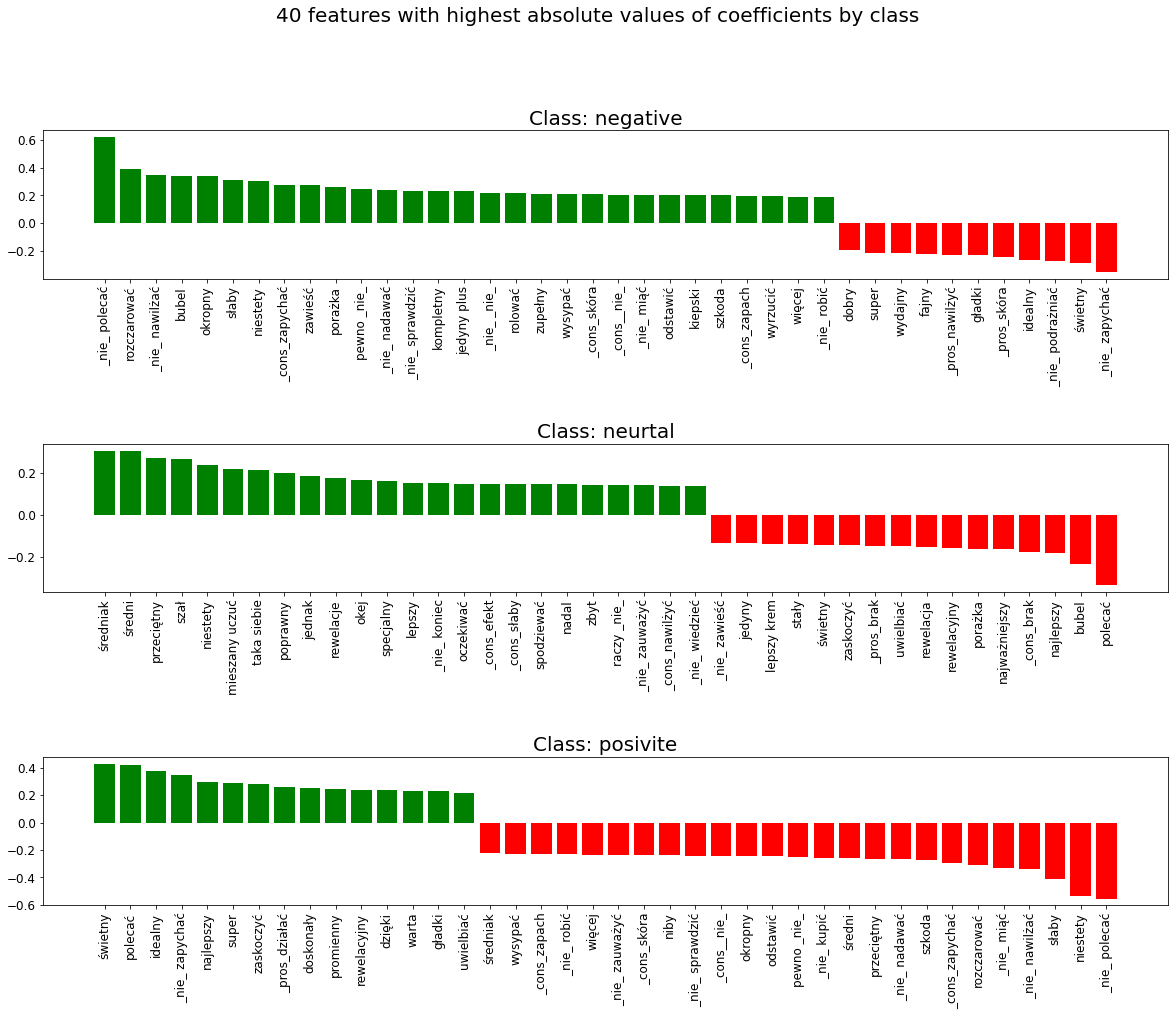

In [11]:
grades_levels = [x for x in np.unique(grades_resampled)]
grades_levels_labels = ['negative', 'neurtal', 'posivite']
n_features = 40

fig, axs = plt.subplots(3, 1, figsize = (20, 15)) 
fig.tight_layout(pad = 14)
fig.suptitle(f'{n_features} features with highest absolute values of coefficients by class', fontsize=20)
    
for i, (grade, axs) in enumerate(zip(grades_levels, axs)):
   
    coefs = model.named_steps['logisticregression'].coef_[i]
    feature_names = model.named_steps['countvectorizer'].get_feature_names()
    idxs = [i for i in np.abs(coefs).argsort()[::-1][:n_features]]
    
    top_features = pd.DataFrame()
    top_features['feature'] = [feature_names[i] for i in idxs]
    top_features['coef'] = [coefs[i] for i in idxs]
    top_features = top_features.sort_values(by='coef', ascending=False)
    
    colors = ['green' if value > 0 else 'red' for value in top_features['coef']]
    axs.set_title(f'Class: {grades_levels_labels[i]}')
    axs.bar(range(n_features), height = top_features['coef'], color = colors)
    axs.tick_params(axis='x', labelrotation=90)
    axs.set_xticks(range(n_features))
    axs.set_xticklabels(top_features['feature'])

plt.show()

## 7. Criticism <a class="anchor" id="chapter7"></a>

There is a room for improvement for the presented analysis. First area is the treatment of negations, which might be done using higher order of n-grams or other more advanced methods. Socondly, the presented approach related to 'pros and cons' was pretty straightforward. It can be futher analysed how to handle various structures of this section (sentences, bullets with nouns/adjectives/verbs or others). Another solution, which might help to improve the performance of models, is usage of embeddings (to better capture the relations between various words).